In [3]:
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
import matplotlib.pyplot as plt


train = pd.read_csv("train_bcg.csv")
test = pd.read_csv("test_bcg.csv")

#One hot encoding for feature imporatnce



train = train.fillna(0)
test = test.fillna(0)


train=train.drop(['User_Traffic'],axis=1)
train=train.drop(['Course_Domain','Course_Type'],axis=1)
test=test.drop(['Course_Domain','Course_Type'],axis=1)
               
feature = [x for x in train.columns if x not in 'Sales']
y = train[['ID','Sales']]
X = train[feature]

X = X.set_index('ID')
test = test.set_index('ID')
y = y.set_index('ID')


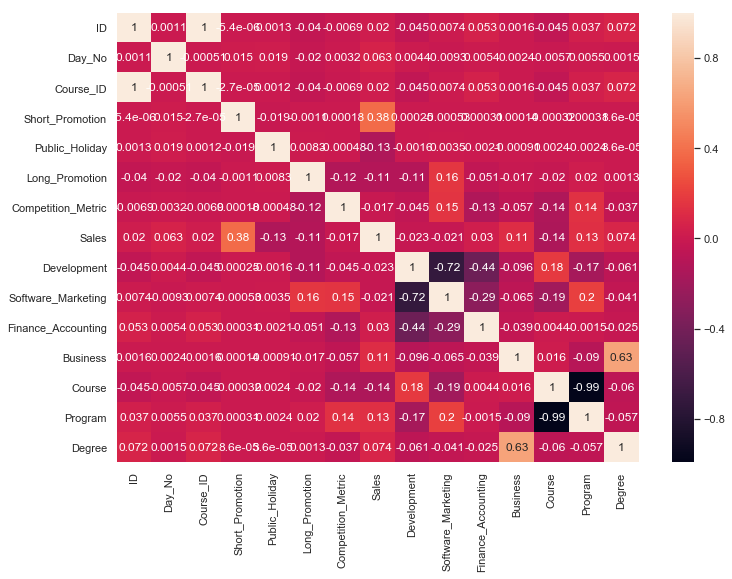

In [7]:
# EDA 

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
train.corr()
sns.heatmap(train.corr(), annot=True)
plt.show()

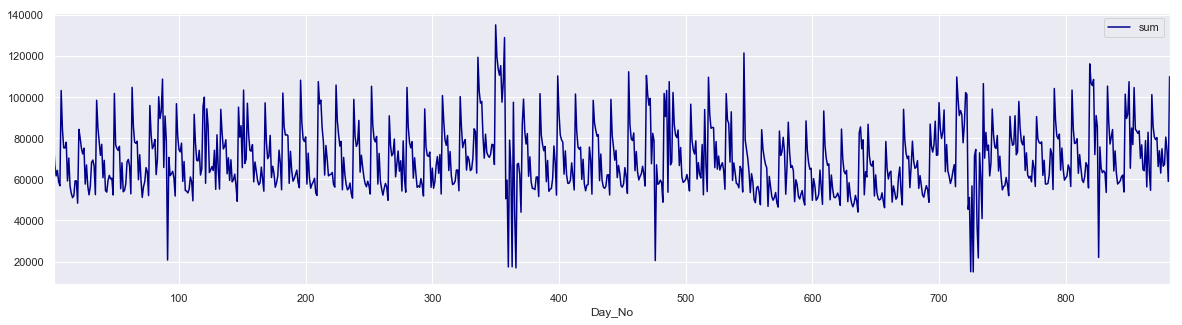

In [8]:
# fig, ax = plt.subplots()
# train['Day_No'].hist(color='#A9C5D3', edgecolor='black',  
#                           grid=False)
# ax.set_title('Developer Age Histogram', fontsize=12)
# ax.set_xlabel('Day_No', fontsize=12)
# ax.set_ylabel('Frequency', fontsize=12)

# train.plot.scatter(x='Day_No',
#                       y='Sales',
#                       c='DarkBlue')

# train.plot.scatter(x='Course_ID',
#                       y='Sales',
#                       c='DarkBlue')

# train['Day_No'].max() #882
# train['Day_No'].min() #1

grouped_sales = train.groupby('Day_No',as_index=False).agg({'Sales': ['sum']})
grouped_sales

grouped_sales.plot.line(x='Day_No',
                      y='Sales',
                      c='DarkBlue',figsize=(20,5))

In [ ]:
###### Multicolinearity check to remove extra variables

import numpy as np
import pandas as pd
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from joblib import Parallel, delayed

# Defining the function that you will run later
def calculate_vif_(X, thresh=5.0):
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print([variables])
    return X[[i for i in variables]]

feature_list = [x for x in train.columns ]
df = train[feature_list] # Selecting your data

df2 = calculate_vif_(df,5) # Actually running the function

In [5]:
###########  Outlier capping ###########
upper_lim = train['Sales'].quantile(.98)
lower_lim = train['Sales'].quantile(.01)
train.loc[(train['Sales'] > upper_lim),'Sales'] = upper_lim
train.loc[(train['Sales'] < lower_lim),'Sales'] = lower_lim


feature = [x for x in train.columns if x not in 'Sales']
y = train[['Sales']]
X = train[feature]


X=X.drop(['Development','Program'],axis=1)
test=test.drop(['Development','Program'],axis=1)

In [10]:
#### Random forest ############

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3,5],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300,1000]  #will chck later with 1000 iterations
# }

param_grid = {
    'bootstrap': [True],
    'max_depth': [80],
    'max_features': [5],
    'min_samples_leaf': [5],
    'min_samples_split': [8],
    'n_estimators': [100]  #will chck later with 1000 iterations
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X, y)
grid_search.best_params_

####based on best parameters build a base model
rf.fit(X,y)



Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished
C:\Users\ssharm35\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\ssharm35\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ssharm35\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

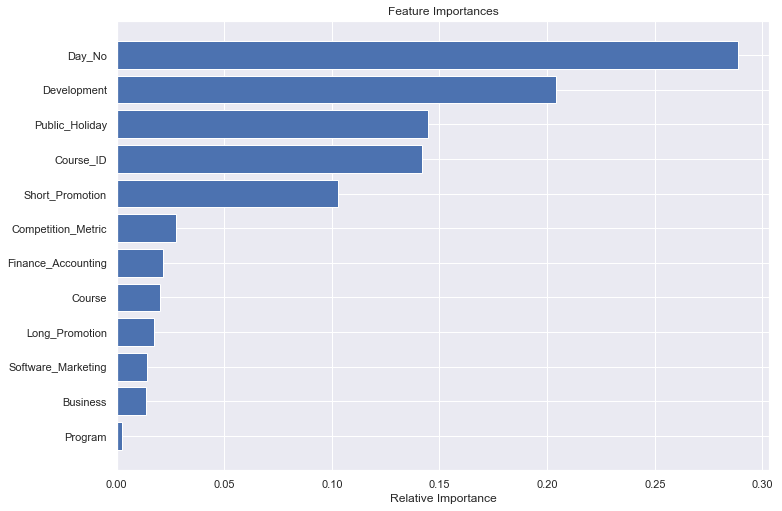

In [11]:
### Feature imporatance 

rf.feature_importances_
features = [x for x in train.columns if x not in ['ID','Sales']]

importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
### Light GBM ####

cate_vars = ['Course_ID','Course_ID', 'Short_Promotion', 'Public_Holiday',
       'Long_Promotion', 'Development', 'Software_Marketing', 'Finance_Accounting', 'Business', 'Course',
       'Program', 'Degree']

X['Competition_Metric'] = X['Competition_Metric']*10
test['Competition_Metric'] = test['Competition_Metric']*10
X.drop(['Day_No'],axis=1)
test.drop(['Day_No'],axis=1)

lgb_train = lgb.Dataset(X, y ,categorical_feature = cate_vars)
lgb_eval = lgb.Dataset(X, y,reference=lgb_train)

params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'rmse'},
        'learning_rate': [0.1,0.2,0.3,0.5],
        'num_leaves': [16,32,64,1024],
    'max_depth' : -1,
        'reg_lambda':0.2,
        'min_child_samples': [10,20,30,40]
        'num_iteration': 1000,   #optimize later
        'verbose': 20,
    'n_estimators': [100,200,300,500]  
    'njobs': -1
    
}

gbm = lgb.train(params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=lgb_eval,
            early_stopping_rounds=10)


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm, param_grid = params, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X, y)
grid_search.best_params_


In [114]:
y_pred = gbm.predict(test)
result = pd.DataFrame(y_pred,index = test.index,columns=['Sales'])
result.to_csv('submission_rf.csv',index=True)